In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression

In [2]:
listings=pd.read_csv('New_Jersey_listings.csv')
listings.head()

,id,last_scraped,Season,name,description,neighborhood_overview,host_id,host_name,host_since,Host Tenure in Years,...,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,amenities
0,40669.0,26-06-2024,Summer,Skyy’s Lounge / Cozy,NaN,The neighborhood is very diverse & friendly sh...,175412,Skyy,20-07-2010,14,...,5.00,4.94,4.94,f,1,0,1,0,0.11,"[""Oven"", ""Ethernet connection"", ""Dishes and si..."
1,215768.0,25-06-2024,Summer,Minutes to Manhattan & Jersey Shore,Walking to distance to Statue of Liberty and E...,"Such close proximity to NYC, 7 minutes on the ...",846837,Charlaine,20-07-2011,13,...,4.88,4.35,4.79,f,2,2,0,0,1.19,"[""Outdoor furniture"", ""Blender"", ""Oven"", ""Dish..."
2,254245.0,25-06-2024,Summer,Minutes to Manhattan and NJ Shore,Walking to distance to Statue of Liberty and E...,"Such close proximity to NYC, 7 minutes on the ...",846837,Charlaine,20-07-2011,13,...,4.84,4.35,4.75,f,2,2,0,0,0.90,"[""Free parking on premises"", ""Blender"", ""Oven""..."
3,269266.0,25-06-2024,Summer,Modern private 2 bedrooms apt minutes to NYC,Enjoy that private luxury two bedrooms apartme...,Our House is located in the Liberty State Park...,1410590,Magda,15-11-2011,13,...,4.67,3.86,4.47,t,13,1,12,0,2.85,"[""Oven"", ""Dishes and silverware"", ""Hot water"",..."
4,270245.0,25-06-2024,Summer,Private room with own bathroom close to NYC,Just for you small bedroom with private bathro...,NaN,1410590,Magda,15-11-2011,13,...,4.72,4.01,4.59,t,13,1,12,0,2.08,"[""Oven"", ""Dishes and silverware"", ""Mosquito ne..."


In [3]:
calendar=pd.read_csv('calendar_updated.csv')
calendar.head()

,listing_id,date,Month,Day,Season,available,price,adjusted_price,minimum_nights,maximum_nights,new_price
0,40669.0,26-06-2024,June,Wednesday,Summer,f,82,NaN,5,365,115.20
1,40669.0,27-06-2024,June,Thursday,Summer,f,82,NaN,5,365,115.86
2,40669.0,28-06-2024,June,Friday,Summer,f,82,NaN,5,365,129.65
3,40669.0,29-06-2024,June,Saturday,Summer,f,82,NaN,5,365,132.76
4,40669.0,30-06-2024,June,Sunday,Summer,f,82,NaN,5,365,127.80


In [4]:
listings["id"] = listings["id"].astype("int32")
calendar["listing_id"] = calendar["listing_id"].astype("int32")

In [5]:
import pandas as pd

# Define file paths
listings_path = 'New_Jersey_listings.csv'
calendar_path = 'calendar_updated.csv'

# Read listings data (all columns)
listings = pd.read_csv(listings_path)

# Read calendar data (only required columns)
calendar = pd.read_csv(calendar_path, usecols=["listing_id", "date", "new_price"])

# Merge datasets on Id and Listing Id
merged_data = pd.merge(listings, calendar, left_on="id", right_on="listing_id", how="inner")

# Drop duplicate rows for each Id
merged_data.drop_duplicates(subset=["id", "listing_id", "date", "new_price"], inplace=True)

# Save merged dataset as 'data' for in-memory usage
data = merged_data

# Save to a compressed file
data.to_csv('merged_filtered_dataset.csv.gz', index=False, compression='gzip')

print("Merging complete. Data is saved in 'data' and also written to 'merged_filtered_dataset.csv.gz'.")


Merging complete. Data is saved in 'data' and also written to 'merged_filtered_dataset.csv.gz'.


## Dataset Cleaning and Preprocessing

In [7]:
data.dtypes


id                   float64
last_scraped          object
Season                object
name                  object
description           object
                      ...   
reviews_per_month    float64
amenities             object
listing_id           float64
date                  object
new_price            float64
Length: 86, dtype: object

In [8]:
data.shape

(629796, 86)

In [9]:
data.isnull().sum()[data.isnull().sum() > 0].sort_values(ascending=False)


calendar_updated               629796
host_about                     307224
neighbourhood                  290042
neighborhood_overview          290042
reviews_per_month              131338
first_review                   131338
review_scores_value            131338
review_scores_location         131338
review_scores_communication    131338
review_scores_checkin          131338
review_scores_cleanliness      131338
review_scores_accuracy         131338
review_scores_rating           131338
last_review                    131338
host_location                  122977
host_neighbourhood              79566
beds                            44142
price                           43777
bathrooms                       43777
host_response_rate              41222
host_response_time              41222
host_acceptance_rate            40858
bedrooms                        14232
description                      7300
host_is_superhost                6205
has_availability                 1460
area        

In [10]:
# 1. Handle Missing Data
# Drop columns with too many missing values (e.g., >50%)
missing_threshold = 0.5
columns_to_drop = [col for col in data.columns if data[col].isnull().mean() > missing_threshold]
data.drop(columns=columns_to_drop, inplace=True)

In [11]:
# Fill missing values for numeric columns with median
data.fillna({col: data[col].median() for col in data.select_dtypes(include=[np.number]).columns}, inplace=True)

In [12]:
# Fill missing values for categorical columns with mode
data.fillna({col: data[col].mode()[0] for col in data.select_dtypes(include=['object']).columns if data[col].mode().size > 0}, inplace=True)


In [13]:
# 2. Standardize Column Names
data.columns = [col.strip().lower().replace(" ", "_") for col in data.columns]

In [14]:
# 3. Correct Data Types
# Convert dates to datetime format
date_columns = ['last_scraped', 'host_since', 'first_review', 'last_review']
for col in date_columns:
    if col in data.columns:
        data[col] = pd.to_datetime(data[col], errors='coerce')

# Convert percentage columns to numeric (e.g., host_response_rate)
percent_columns = ['host_response_rate', 'host_acceptance_rate']
for col in percent_columns:
    if col in data.columns:
        data[col] = data[col].str.replace('%', '').astype(float) / 100

C:\Users\DELL\AppData\Local\Temp\ipykernel_6836\4077517553.py:6: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data[col] = pd.to_datetime(data[col], errors='coerce')
C:\Users\DELL\AppData\Local\Temp\ipykernel_6836\4077517553.py:6: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data[col] = pd.to_datetime(data[col], errors='coerce')
C:\Users\DELL\AppData\Local\Temp\ipykernel_6836\4077517553.py:6: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data[col] = pd.to_datetime(data[col], errors='coerce')
C:\Users\DELL\AppData\Local\Temp\ipykernel_6836\4077517553.py:6: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was sp

In [15]:
# 4. Feature Engineering

# Calculate host tenure

data['host_tenure_years'] = (pd.Timestamp.now() - data['host_since']).dt.days / 365.25

# Calculate price per bedroom
data['price_per_bedroom'] = data['price'] / data['bedrooms']


In [16]:
data.head()

,id,last_scraped,season,name,description,neighborhood_overview,host_id,host_name,host_since,host_tenure_in_years,...,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,amenities,listing_id,date,new_price,host_tenure_years,price_per_bedroom
0,40669.0,2024-06-26,Summer,Skyy’s Lounge / Cozy,Come to our 2-bedroom apartment in Jersey City...,The neighborhood is very diverse & friendly sh...,175412,Skyy,2010-07-20,14,...,0,1,0,0.11,"[""Oven"", ""Ethernet connection"", ""Dishes and si...",40669.0,26-06-2024,115.20,14.469541,128.0
1,40669.0,2024-06-26,Summer,Skyy’s Lounge / Cozy,Come to our 2-bedroom apartment in Jersey City...,The neighborhood is very diverse & friendly sh...,175412,Skyy,2010-07-20,14,...,0,1,0,0.11,"[""Oven"", ""Ethernet connection"", ""Dishes and si...",40669.0,27-06-2024,115.86,14.469541,128.0
2,40669.0,2024-06-26,Summer,Skyy’s Lounge / Cozy,Come to our 2-bedroom apartment in Jersey City...,The neighborhood is very diverse & friendly sh...,175412,Skyy,2010-07-20,14,...,0,1,0,0.11,"[""Oven"", ""Ethernet connection"", ""Dishes and si...",40669.0,28-06-2024,129.65,14.469541,128.0
3,40669.0,2024-06-26,Summer,Skyy’s Lounge / Cozy,Come to our 2-bedroom apartment in Jersey City...,The neighborhood is very diverse & friendly sh...,175412,Skyy,2010-07-20,14,...,0,1,0,0.11,"[""Oven"", ""Ethernet connection"", ""Dishes and si...",40669.0,29-06-2024,132.76,14.469541,128.0
4,40669.0,2024-06-26,Summer,Skyy’s Lounge / Cozy,Come to our 2-bedroom apartment in Jersey City...,The neighborhood is very diverse & friendly sh...,175412,Skyy,2010-07-20,14,...,0,1,0,0.11,"[""Oven"", ""Ethernet connection"", ""Dishes and si...",40669.0,30-06-2024,127.80,14.469541,128.0


## Analysis

In [18]:
# Ensure unique_data is a copy
unique_data = data.drop_duplicates(subset="id").copy()

# Replace infinities with NaN using .loc
unique_data.loc[:, 'price'] = unique_data['price'].replace([np.inf, -np.inf], np.nan)

# Drop rows with NaN in the 'price' column
unique_data = unique_data.dropna(subset=['price'])

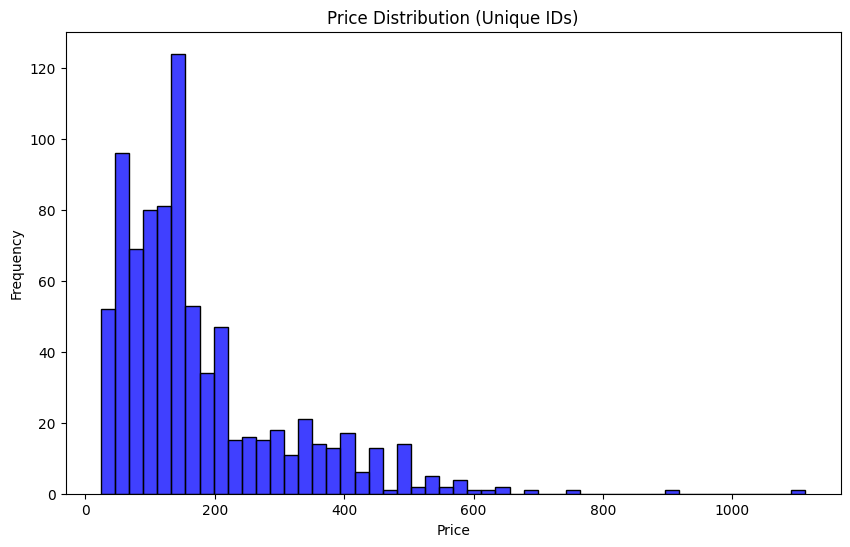

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(unique_data['price'], bins=50, kde=False, color='blue')
plt.title('Price Distribution (Unique IDs)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()


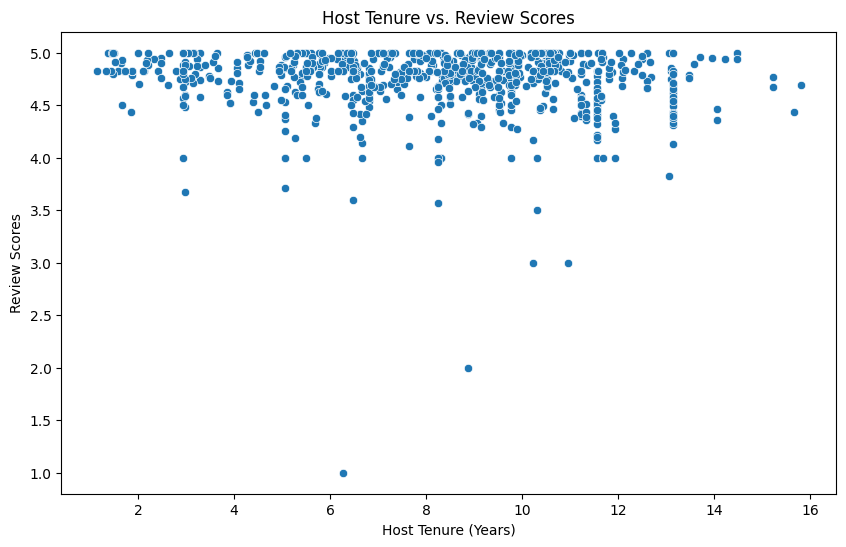

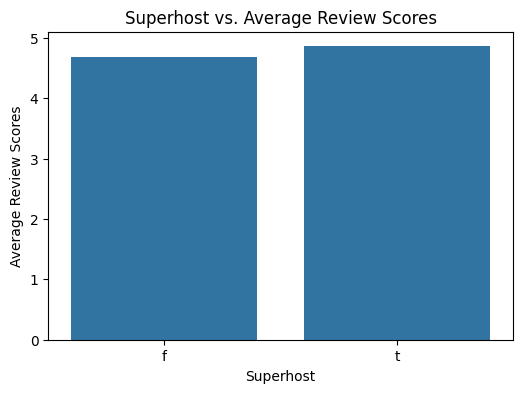

In [20]:
# 2. Analyze Host Characteristics
plt.figure(figsize=(10, 6))
sns.scatterplot(x='host_tenure_years', y='review_scores_rating', data=unique_data)
plt.title('Host Tenure vs. Review Scores')
plt.xlabel('Host Tenure (Years)')
plt.ylabel('Review Scores')
plt.show()


superhost_review = unique_data.groupby('host_is_superhost')['review_scores_rating'].mean()
plt.figure(figsize=(6, 4))
sns.barplot(x=superhost_review.index, y=superhost_review.values)
plt.title('Superhost vs. Average Review Scores')
plt.xlabel('Superhost')
plt.ylabel('Average Review Scores')
plt.show()

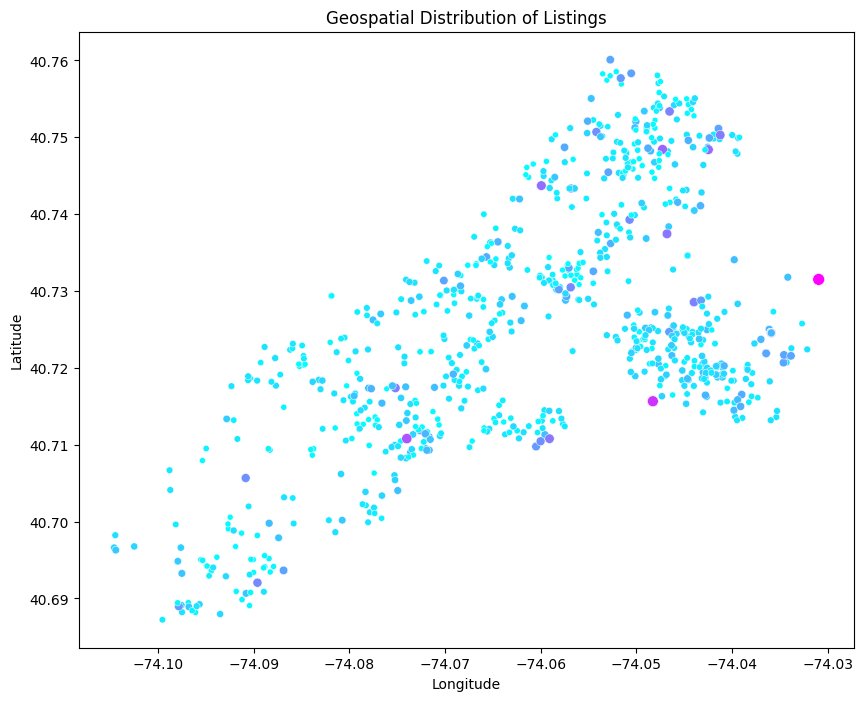

In [21]:
# 3. Geospatial Analysis
plt.figure(figsize=(10, 8))
sns.scatterplot(x='longitude', y='latitude', hue='price', size='price', data=unique_data, palette='cool', legend=False)
plt.title('Geospatial Distribution of Listings')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

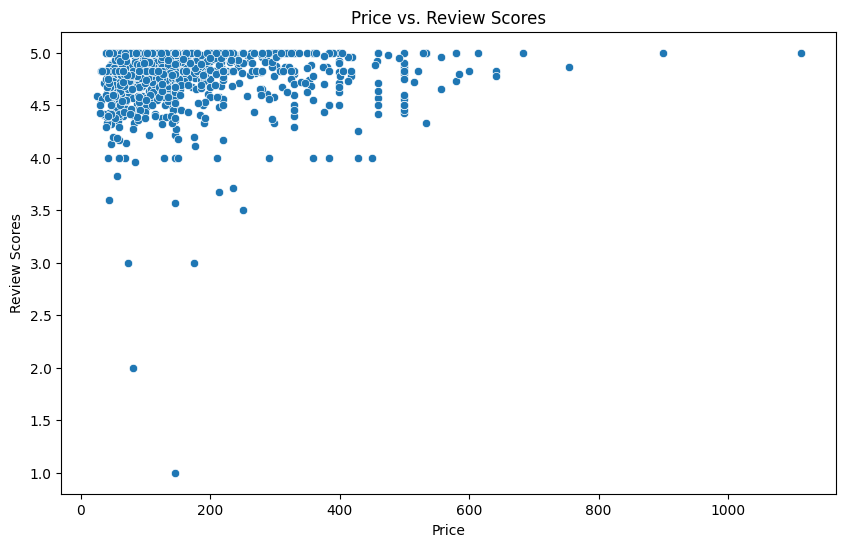

In [22]:
# 4. Review Analysis
plt.figure(figsize=(10, 6))
sns.scatterplot(x='price', y='review_scores_rating', data=unique_data)
plt.title('Price vs. Review Scores')
plt.xlabel('Price')
plt.ylabel('Review Scores')
plt.show()

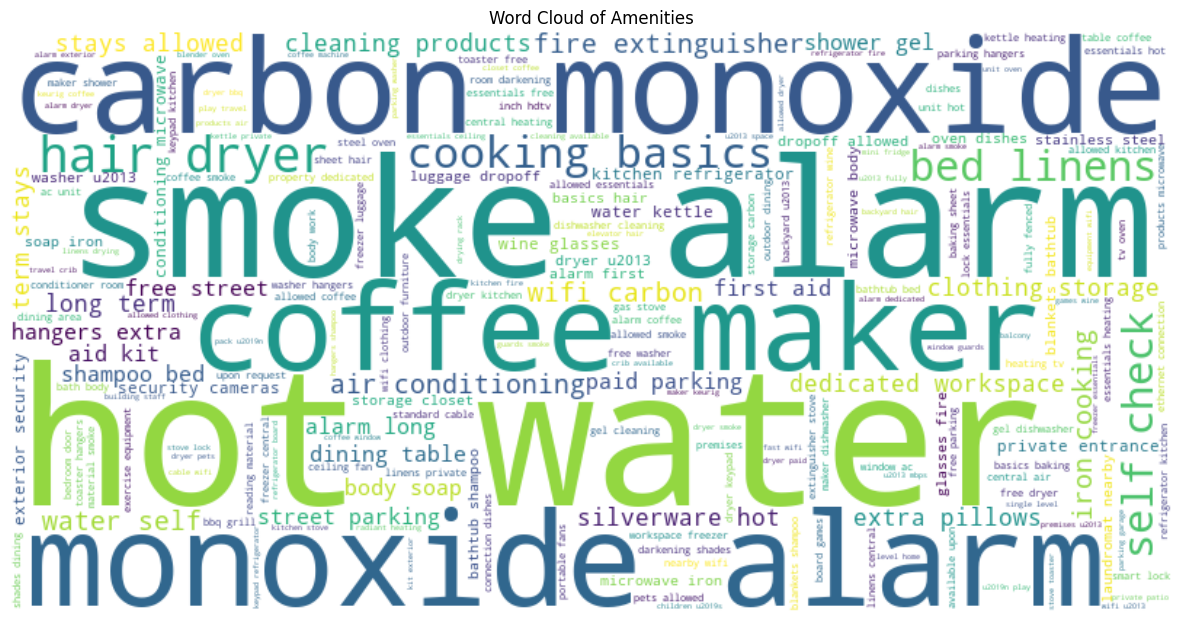

In [23]:
# Combine all amenities into a single string for the word cloud

amenities_text = " ".join(
    unique_data['amenities']
    .dropna()
    .str.strip('[]')
    .str.replace('"', '')
    .str.replace(',', ' ')
    .str.lower()
)

# Generate the word cloud
amenities_wordcloud = WordCloud(
    max_words=200, 
    background_color="white", 
    width=800, 
    height=400
).generate(amenities_text)

# Plot the word cloud
plt.figure(figsize=(15, 10))
plt.imshow(amenities_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Amenities")
plt.show()



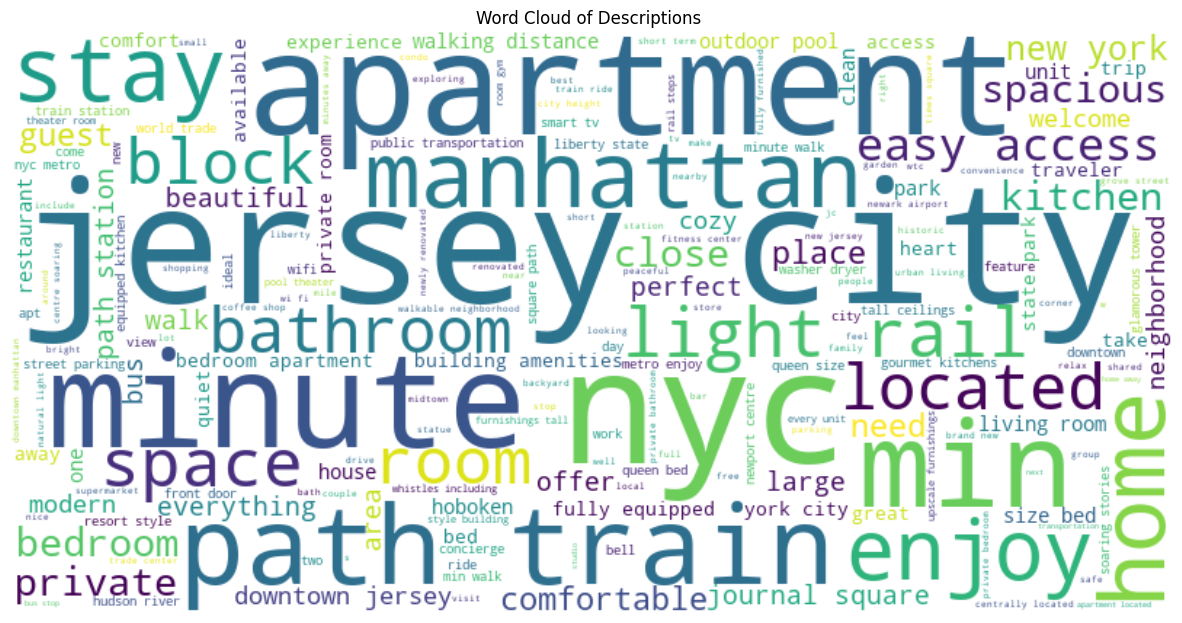

In [24]:
from wordcloud import WordCloud, STOPWORDS

description_text = " ".join(unique_data['description'].dropna().astype(str).str.lower())

custom_stopwords = STOPWORDS.union({
    'and', 'or', 'br', 'the', 'a', 'in', 'of', 'to', 'for', 'is', 
    'on', 'at', 'with', 'by', 'from', 'it', 'this', 'that', 'are', 
    'an', 'as', 'if', 'but', 'not', 'be', 'was', 'we', 'you', 
    'have', 'has', 'had', 'will', 'can', 'i', 'me', 'my', 'they', 
    'their', 'our', 'ours', 'your', 'yours'
})

description_text = " ".join(unique_data['description'].dropna().astype(str).str.lower())

# Create the word cloud with custom stopwords
description_wordcloud = WordCloud(
    max_words=200,
    background_color="white",
    width=800,
    height=400,
    stopwords=custom_stopwords  # Remove both default and custom stopwords
).generate(description_text)

# Plot the word cloud
plt.figure(figsize=(15, 10))
plt.imshow(description_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Descriptions ")
plt.show()

## Correlation

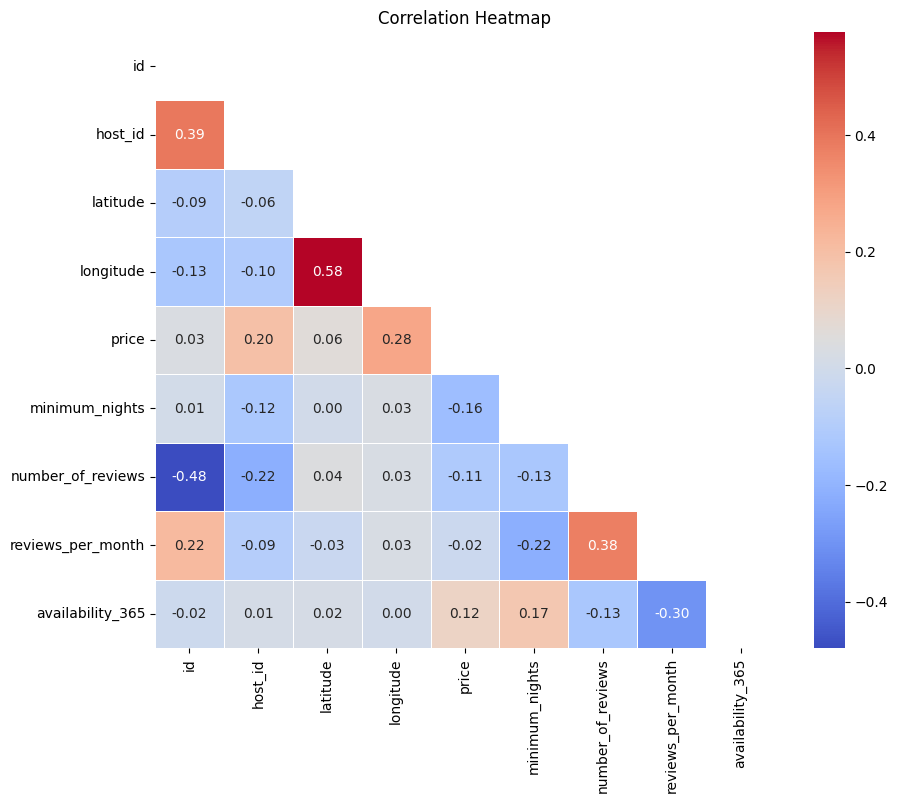

In [26]:
# Define the columns for correlation analysis
columns_for_correlation = [
    "id", "host_id", "latitude", "longitude", "price",
    "minimum_nights", "number_of_reviews", "reviews_per_month",
    "availability_365"
]

# Ensure these columns exist in the dataset
valid_columns = [col for col in columns_for_correlation if col in data.columns]

# Compute the correlation matrix
correlation_matrix = data[valid_columns].corr()

# Mask the upper triangle for better visualization
mask = np.zeros_like(correlation_matrix)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", mask=mask, linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()


### Reviews per month shows a moderate positive correlation with availability_365, indicating that listings available for more days tend to receive more reviews monthly.Reviews per month shows a moderate positive correlation with availability_365, indicating that listings available for more days tend to receive more reviews monthly.
### Target Pricing: As price does not correlate with reviews or availability, consider pricing strategies based on other competitive factors, such as amenities or neighborhood features.

## Violin Plot: Relation between neighbourhood (cleansed) and availability


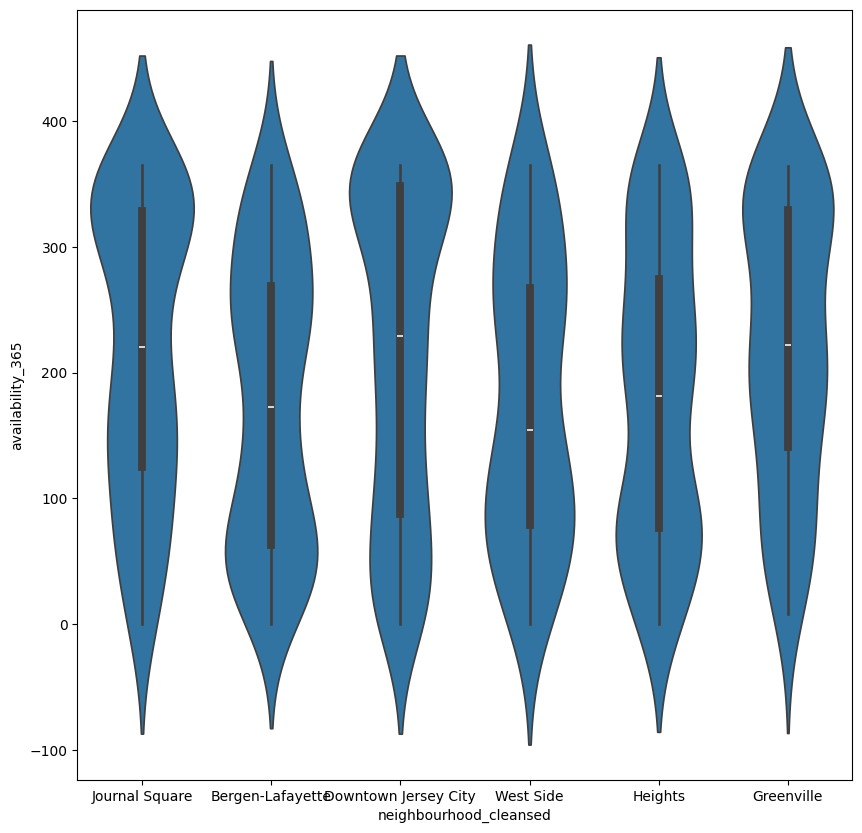

In [29]:
plt.figure(figsize=(10,10))
ax = sns.violinplot(data=unique_data, x="neighbourhood_cleansed", y="availability_365")


### Listings in neighborhoods like Downtown Jersey City and Journal Square show higher median availability (200–300 days), indicating more full-time Airbnb activity, while neighborhoods like Bergen-Lafayette and Greenville have a wider spread, reflecting more diverse usage patterns.

<Axes: xlabel='neighbourhood_cleansed', ylabel='price'>

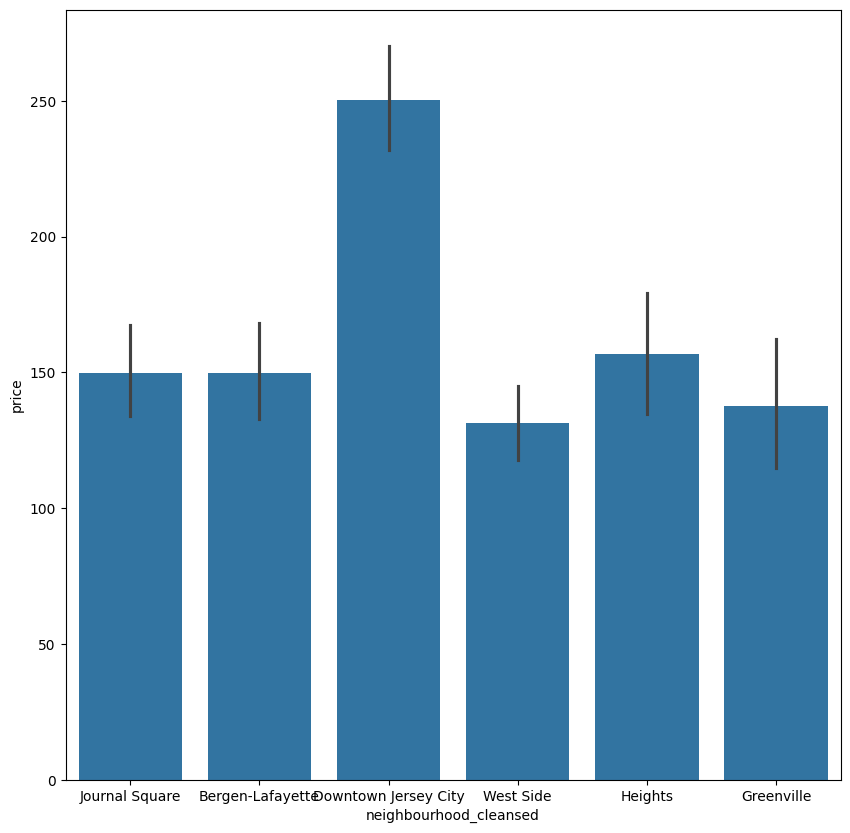

In [31]:
plt.figure(figsize=(10,10))
sns.barplot(data=unique_data, x='neighbourhood_cleansed', y='price')

### Bar plot plotted between neighbourhood group and price showas that Downtown Jersey City has the most expensive prices

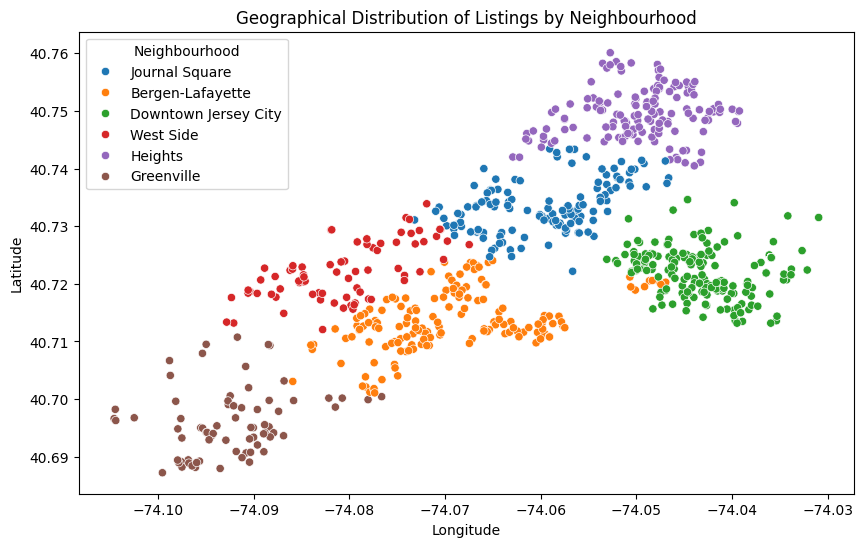

In [33]:
# Scatterplot with explicit keyword arguments
plt.figure(figsize=(10, 6))
sns.scatterplot(x=unique_data.longitude, y=unique_data.latitude, hue=unique_data.neighbourhood_cleansed)
plt.title("Geographical Distribution of Listings by Neighbourhood")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Neighbourhood")
plt.show()


### Listings are densely clustered in neighborhoods like Downtown Jersey City and Heights, while areas like Greenville have fewer, more spread-out listings, indicating differences in density and geographic spread across neighborhoods.

## Now let's categorise rooms based on price Let price less than 75 dollars be low, between 75 and 500 dollars be medium and above 500 dollars be high

price_category
Medium    643
Low       167
High       21
Name: count, dtype: int64


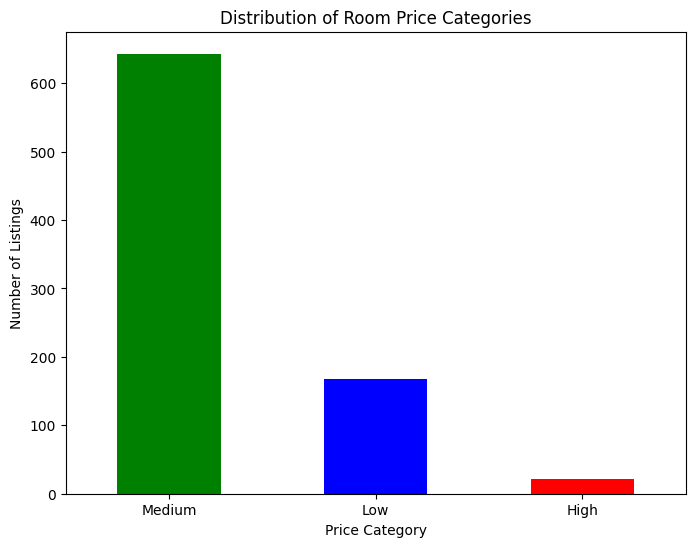

In [36]:
# Categorize rooms based on price into 'Low', 'Medium', and 'High'
def categorize_price(price):
    if price < 75:
        return 'Low'
    elif 75 <= price <= 500:
        return 'Medium'
    else:
        return 'High'

# Apply the categorization to the 'price' column

unique_data['price_category'] = unique_data['price'].apply(categorize_price)

# Display the count of each category
price_category_counts = unique_data['price_category'].value_counts()
print(price_category_counts)

# Plot the distribution of price categories
plt.figure(figsize=(8, 6))
price_category_counts.plot(kind='bar', color=['green', 'blue', 'red'])
plt.title("Distribution of Room Price Categories")
plt.xlabel("Price Category")
plt.ylabel("Number of Listings")
plt.xticks(rotation=0)
plt.show()



### Most of the rooms fall in the Medium (75-500 $) category followed by Low and High range rooms.Very few people prefer to live in high priced rooms.

## Analysing the number of reviews

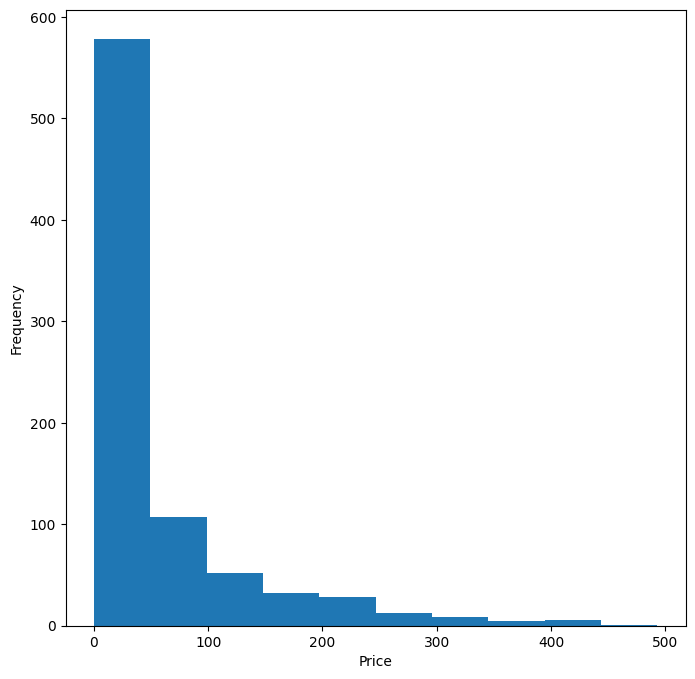

In [39]:
plt.figure(figsize=(8,8))
unique_data['number_of_reviews'].plot(kind='hist')
plt.xlabel("Price")
plt.ioff()
plt.show()

### From the histogram we can see that low cost rooms or in range 0-50 $ have more reviews.This shows us that people who pay more for the rooms generally dont write reviews.It is observed people write reviews more if they are not happy with their experience.In case of costly rooms there is high possibility that the customers are happy.So they dont write much reviews.


# Models and Predictions
# Price Prediction based on name

## listing classification as cheap or expensive just based on the name

### Remove punctuation, digits and special characters

In [51]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import os

# First ensure we have the basic punkt tokenizer
nltk.download('punkt')
nltk.download('stopwords')

def tokenize_no_stopwords(line):
    # Use a simpler tokenization approach with basic punkt
    if not isinstance(line, str):
        return ""
    # Use split() instead of word_tokenize
    tokens = line.split()
    tokens_no_stop = [w for w in tokens if w not in stopwords.words('english')]
    return " ".join(tokens_no_stop)

unique_data['final_name'] = unique_data['clean_name'].apply(tokenize_no_stopwords)
unique_data[['clean_name', 'final_name']].head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,clean_name,final_name
0,skyy s lounge cozy,skyy lounge cozy
365,minutes to manhattan jersey shore,minutes manhattan jersey shore
730,minutes to manhattan and nj shore,minutes manhattan nj shore
1095,modern private bedrooms apt minutes to nyc,modern private bedrooms apt minutes nyc
1460,private room with own bathroom close to nyc,private room bathroom close nyc


In [53]:
import re

# Function to clean text by removing punctuation, digits, and special characters
def remove_punctuation_digits_specialchar(line):
    return re.sub('[^A-Za-z]+', ' ', line).lower()

# Apply the cleaning function and avoid the SettingWithCopyWarning
unique_data = unique_data.copy()  # Ensure a deep copy to avoid modifying the original DataFrame
unique_data.loc[:, 'clean_name'] = unique_data['name'].apply(remove_punctuation_digits_specialchar)

# Display cleaned text alongside the original name
print(unique_data[['name', 'clean_name']].head())


                                              name  \
0                             Skyy’s Lounge / Cozy   
365            Minutes to Manhattan & Jersey Shore   
730              Minutes to Manhattan and NJ Shore   
1095  Modern private 2 bedrooms apt minutes to NYC   
1460   Private room with own bathroom close to NYC   

                                       clean_name  
0                              skyy s lounge cozy  
365             minutes to manhattan jersey shore  
730             minutes to manhattan and nj shore  
1095   modern private bedrooms apt minutes to nyc  
1460  private room with own bathroom close to nyc  


### Remove stop words

### Now lets define a price above 300 as expensive and below 300 as cheap.
### We divide dataset into 80% training and 20% as test dataset
### We use TF-IDF metric which we have learnt in class to represent the weights of each feature

### LGBM classifier is used which is similar to decision trees.

In [59]:
pip install lightgbm

   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 1.4/1.4 MB 8.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, classification_report
from sklearn.utils import resample  # Alternative to RandomOverSampler if needed

def classify_as_cheap_or_expensive(line):
    if line > 300:
        return 1
    else:
        return 0

# Apply the classification function
unique_data['target'] = unique_data['price'].apply(classify_as_cheap_or_expensive)
print(unique_data['target'].value_counts())

# Split the data into training and testing sets
train, test = train_test_split(unique_data, test_size=0.2, random_state=315, stratify=unique_data['target'])

X_train, y_train = train['final_name'], train['target']
X_test, y_test = test['final_name'], test['target']

# TF-IDF vectorization
vect = TfidfVectorizer()
X_train = vect.fit_transform(X_train)
X_test = vect.transform(X_test)

# Oversample the minority class using resample
X_train_array = X_train.toarray()
X_train_resampled, y_train_resampled = resample(
    X_train_array, y_train, replace=True, n_samples=len(y_train), random_state=1
)

# Use LightGBM Classifier
clf = LGBMClassifier(random_state=315, verbose=-1)
clf.fit(X_train_resampled, y_train_resampled)

# Make predictions
preds = clf.predict(X_test)

# Classification metrics
print(classification_report(y_test, preds))
print("Accuracy: {0:.3f}".format(accuracy_score(y_test, preds)))
print("Recall: {0:.3f}".format(recall_score(y_test, preds)))

target
0    695
1    136
Name: count, dtype: int64
              precision    recall  f1-score   support

           0       0.90      0.95      0.93       140
           1       0.65      0.48      0.55        27

    accuracy                           0.87       167
   macro avg       0.78      0.72      0.74       167
weighted avg       0.86      0.87      0.87       167

Accuracy: 0.874
Recall: 0.481


### The scores aren't perfect but taking into account that the predicting model is built solely on textual descriptions of a listing, it seems like the words in Airbnb titles actually do matter!


In [63]:
unique_data.drop(columns=['target', 'clean_name'], axis=1, inplace=True)


In [65]:
unique_data.head()


,id,last_scraped,season,name,description,neighborhood_overview,host_id,host_name,host_since,host_tenure_in_years,...,calculated_host_listings_count_shared_rooms,reviews_per_month,amenities,listing_id,date,new_price,host_tenure_years,price_per_bedroom,price_category,final_name
0,40669.0,2024-06-26,Summer,Skyy’s Lounge / Cozy,Come to our 2-bedroom apartment in Jersey City...,The neighborhood is very diverse & friendly sh...,175412,Skyy,2010-07-20,14,...,0,0.11,"[""Oven"", ""Ethernet connection"", ""Dishes and si...",40669.0,26-06-2024,115.20,14.469541,128.0,Medium,skyy lounge cozy
365,215768.0,2024-06-25,Summer,Minutes to Manhattan & Jersey Shore,Walking to distance to Statue of Liberty and E...,"Such close proximity to NYC, 7 minutes on the ...",846837,Charlaine,2011-07-20,13,...,0,1.19,"[""Outdoor furniture"", ""Blender"", ""Oven"", ""Dish...",215768.0,25-06-2024,209.57,13.470226,157.0,Medium,minutes manhattan jersey shore
730,254245.0,2024-06-25,Summer,Minutes to Manhattan and NJ Shore,Walking to distance to Statue of Liberty and E...,"Such close proximity to NYC, 7 minutes on the ...",846837,Charlaine,2011-07-20,13,...,0,0.90,"[""Free parking on premises"", ""Blender"", ""Oven""...",254245.0,25-06-2024,200.88,13.470226,157.0,Medium,minutes manhattan nj shore
1095,269266.0,2024-06-25,Summer,Modern private 2 bedrooms apt minutes to NYC,Enjoy that private luxury two bedrooms apartme...,Our House is located in the Liberty State Park...,1410590,Magda,2011-11-15,13,...,0,2.85,"[""Oven"", ""Dishes and silverware"", ""Hot water"",...",269266.0,25-06-2024,111.50,13.147159,62.5,Medium,modern private bedrooms apt minutes nyc
1460,270245.0,2024-06-25,Summer,Private room with own bathroom close to NYC,Just for you small bedroom with private bathro...,Newport Centre - 0.5 miles; <br />J. Owen Grun...,1410590,Magda,2011-11-15,13,...,0,2.08,"[""Oven"", ""Dishes and silverware"", ""Mosquito ne...",270245.0,25-06-2024,49.91,13.147159,54.0,Low,private room bathroom close nyc


### Now for using other models, let us first convert the categorical features into numeric by using encoding


In [67]:
from sklearn.preprocessing import LabelEncoder

# Encoding neighbourhood_cleansed and creating a new column
le_neighbourhood = LabelEncoder()
unique_data['neighbourhood_cleansed_encoded'] = le_neighbourhood.fit_transform(unique_data['neighbourhood_cleansed'])

# Encoding property_type and creating a new column
le_property_type = LabelEncoder()
unique_data['property_type_encoded'] = le_property_type.fit_transform(unique_data['property_type'])

# Encoding room_type and creating a new column
le_room_type = LabelEncoder()
unique_data['room_type_encoded'] = le_room_type.fit_transform(unique_data['room_type'])

# Display the new encoded columns alongside the original ones
print(unique_data[['neighbourhood_cleansed', 'neighbourhood_cleansed_encoded', 
                   'property_type', 'property_type_encoded', 
                   'room_type', 'room_type_encoded']].head())


     neighbourhood_cleansed  neighbourhood_cleansed_encoded  \
0            Journal Square                               4   
365        Bergen-Lafayette                               0   
730        Bergen-Lafayette                               0   
1095       Bergen-Lafayette                               0   
1460       Bergen-Lafayette                               0   

                  property_type  property_type_encoded        room_type  \
0         Private room in condo                     12     Private room   
365                 Entire home                      3  Entire home/apt   
730                 Entire home                      3  Entire home/apt   
1095         Entire rental unit                      6  Entire home/apt   
1460  Private room in townhouse                     17     Private room   

      room_type_encoded  
0                     2  
365                   0  
730                   0  
1095                  0  
1460                  2  


## Linear Regression Model

### Prices are not normally distributed as well as there is alot of noise.Hence instead of considering y, we consider log(y)


In [71]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# First, filter the data
unique_data = unique_data[unique_data.price > 0]
unique_data = unique_data[unique_data.availability_365 > 0]

# Create a copy to avoid modifying original data
X = unique_data[['neighbourhood_cleansed', 'room_type', 'property_type', 'minimum_nights',
                 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count',
                 'availability_365']].copy()

# Handle categorical variables using LabelEncoder
categorical_columns = ['neighbourhood_cleansed', 'room_type', 'property_type']
le = LabelEncoder()

for column in categorical_columns:
    X[column] = le.fit_transform(X[column].astype(str))

# Handle missing values if any
X = X.fillna(0)

# Create target variable
y = np.log10(unique_data['price'])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

# Fit the model
lm = LinearRegression()
lm.fit(X_train, y_train)

# Make predictions
y_predicts = lm.predict(X_test)

# Print metrics
print("""
        Mean Squared Error: {:.4f}
        R2 Score: {:.2f}%
        Mean Absolute Error: {:.4f}
     """.format(
        np.sqrt(mean_squared_error(y_test, y_predicts)),
        r2_score(y_test, y_predicts) * 100,
        mean_absolute_error(y_test, y_predicts)
))


        Mean Squared Error: 0.2167
        R2 Score: 48.33%
        Mean Absolute Error: 0.1673
     


## Decision Tree model

In [75]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Define the LightGBM Regressor
lgbm_model = LGBMRegressor(
    max_depth=3,
    n_estimators=100,
    learning_rate=0.1,
    random_state=0
)

# Train the model
lgbm_model.fit(X_train, y_train)

# Predict on the test set
y_predicts = lgbm_model.predict(X_test)

# Evaluate the model
print("Mean Absolute Error:", mean_absolute_error(y_test, y_predicts))
print("Mean Squared Error:", np.sqrt(mean_squared_error(y_test, y_predicts)))
print("R2 Score:", r2_score(y_test, y_predicts))

# Median Absolute Deviation (MAD)
mad = np.mean(abs(np.multiply(np.array(y_test.T - y_predicts), np.array(1 / y_test))))
print("Median Absolute Deviation (MAD):", mad)


Mean Absolute Error: 0.12522021991058696
Mean Squared Error: 0.17303703812263332
R2 Score: 0.6706774833545832
Median Absolute Deviation (MAD): 0.05953817754790723


## Ridge Model

In [77]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the Ridge Regression model
ridge_model = Ridge(alpha=0.01)  # Removed 'normalize' parameter
ridge_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_predicts = ridge_model.predict(X_test_scaled)

# Evaluate the model
print("""
Mean Squared Error: {}
R2 Score: {}
Mean Absolute Error: {}
 """.format(
    np.sqrt(mean_squared_error(y_test, y_predicts)),
    r2_score(y_test, y_predicts) * 100,
    mean_absolute_error(y_test, y_predicts)
    ))



Mean Squared Error: 0.2167463020664291
R2 Score: 48.32902296889983
Mean Absolute Error: 0.16725128498153286
 


## Lasso Model

In [79]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the Lasso Regression model
lasso_model = Lasso(alpha=0.001)  # Removed 'normalize' parameter
lasso_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_predicts = lasso_model.predict(X_test_scaled)

# Evaluate the model
print("""
Mean Squared Error: {}
R2 Score: {}
Mean Absolute Error: {}
     """.format(
        np.sqrt(mean_squared_error(y_test, y_predicts)),
        r2_score(y_test, y_predicts) * 100,
        mean_absolute_error(y_test, y_predicts)
        ))



Mean Squared Error: 0.21621208977732875
R2 Score: 48.58341489082797
Mean Absolute Error: 0.1669894714214228
     


## We can see that Decision Tree model has the highest R^2 value and least error. Hence it is the best model.


In [81]:
unique_data.head()


,id,last_scraped,season,name,description,neighborhood_overview,host_id,host_name,host_since,host_tenure_in_years,...,listing_id,date,new_price,host_tenure_years,price_per_bedroom,price_category,final_name,neighbourhood_cleansed_encoded,property_type_encoded,room_type_encoded
0,40669.0,2024-06-26,Summer,Skyy’s Lounge / Cozy,Come to our 2-bedroom apartment in Jersey City...,The neighborhood is very diverse & friendly sh...,175412,Skyy,2010-07-20,14,...,40669.0,26-06-2024,115.20,14.469541,128.0,Medium,skyy lounge cozy,4,12,2
365,215768.0,2024-06-25,Summer,Minutes to Manhattan & Jersey Shore,Walking to distance to Statue of Liberty and E...,"Such close proximity to NYC, 7 minutes on the ...",846837,Charlaine,2011-07-20,13,...,215768.0,25-06-2024,209.57,13.470226,157.0,Medium,minutes manhattan jersey shore,0,3,0
730,254245.0,2024-06-25,Summer,Minutes to Manhattan and NJ Shore,Walking to distance to Statue of Liberty and E...,"Such close proximity to NYC, 7 minutes on the ...",846837,Charlaine,2011-07-20,13,...,254245.0,25-06-2024,200.88,13.470226,157.0,Medium,minutes manhattan nj shore,0,3,0
1095,269266.0,2024-06-25,Summer,Modern private 2 bedrooms apt minutes to NYC,Enjoy that private luxury two bedrooms apartme...,Our House is located in the Liberty State Park...,1410590,Magda,2011-11-15,13,...,269266.0,25-06-2024,111.50,13.147159,62.5,Medium,modern private bedrooms apt minutes nyc,0,6,0
1460,270245.0,2024-06-25,Summer,Private room with own bathroom close to NYC,Just for you small bedroom with private bathro...,Newport Centre - 0.5 miles; <br />J. Owen Grun...,1410590,Magda,2011-11-15,13,...,270245.0,25-06-2024,49.91,13.147159,54.0,Low,private room bathroom close nyc,0,17,2
